# Floating Marine Debris

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background

- Downloaded the **Floating-Marine-Debris-Data** from https://github.com/miguelmendesduarte/Floating-Marine-Debris-Data as `floating_marine_debris.geojson`.
- Loaded the dataset into QGIS.
- In QGIS, drew a bounding box around the data off the coast of Africa resulting in the file:
    - `south_africa_bounding_box.geojson`
    - `ghana_bounding_box.geojson`
- Used the above bounding boxes to clip the `floating_marine_debris.geojson`  data. This resulted in two datasets :
    - Off the coast of South Africa labelled `floating_marine_debris_south_africa.geojson`
    - Off the coast of Ghana labelled `floating_marine_debris_ghana.geojson`
- Uploaded the two datasets above into the Analysis Sandbox.

>💡 The [labels](https://github.com/miguelmendesduarte/Floating-Marine-Debris-Data#data-sets-and-python-file) for the Floating Marine Dataset are: Label = 1 (WATER), 2 (PLASTIC), 3 (DRIFTWOOD), 4 (SEAWEED), 5 (PUMICE), 6 (SEA_SNOT), 7 (SEA_FOAM).

- Examined both datasets:
    - The dataset in Ghana only has label 4 which means that the only points collected are for sea weed. 
    - The dataset for South Africa has only label 2 which means that the only points collected are for plastic.
    
## Description

- The purpose of this notebook is to:
    1. Calculate the Floating Debris  Index, Plastic Index, and Floating Algae Index spectral indices.
    2. Determine whether  the Floating Debris Index , Plastic Index, and Floating Algae Index calculated from Digital Earth Africa’s Sentinel-2 data will match the FDI, FAI and PI values from the Floating Marine Debris Dataset.
    3. Determine the Sentinel-2 image to use as the classification input image or thresholding image with the Floating Marine Debris Dataset.
    
    
 ## Results
 
The results indicate that based on the band values provided with the Floating Marine Debris dataset, the Sentinel -2 image to use for detecting seaweed for Ghana is the image dated `2018-10-31` loaded using `dc.load`  and for detecting plastics for South Africa is the image dated `2019-04-24` loaded using `dc.load`.  

The values from the Sentinel-2 data for the specified dates loaded are not an exact match, but their trend matches closely with the FDI values provided in the Floating Marine Debris Dataset. 

## Spectral indices

### Floating Algae Index 


\begin{equation}
\text{FAI} = (R_{rs,NIR} - R_{rs, RED}) + (R_{rs, RED} - R_{rs, SWIR}) * \frac{(\lambda_{NIR} - \lambda_{RED})}{(\lambda_{SWIR} - \lambda_{RED})}
\end{equation}

where $R_{rs,NIR}$, $R_{rs, RED}$, $R_{rs, SWIR}$ are the reflectance values in the near infrared, red and short wave infrared bands, respectively, $λ_i$ are the wavelength with subscript band name. 

### Floating Debris Index (FDI) 

\begin{equation}
\text{FDI} = R_{rs,NIR} - (R_{rs, RE2} + (R_{rs, SWIR1} - R_{rs, RE2}) * \frac{(\lambda_{NIR} - \lambda_{RED})}{(\lambda_{SWIR1} - \lambda_{RED})} * 10)
\end{equation}


where $R_{rs,NIR}$, $R_{rs, RE2}$, $R_{rs, SWIR1}$ are the reflectance values in the near infrared, red edge 2, and
short-wave infrared bands, respectively, $λ_i$ are the wavelength with subscript band name. 


>Note wavelength values are the central wavelengths from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2


### Plastic Index

\begin{equation}
\text{Plastic Index} =  \frac{R_{rs,NIR}}{ R_{rs,NIR} +  R_{rs,RED}} 
\end{equation}

In [1]:
# Load the necessary python packages. 
%matplotlib inline
import os
import datacube

from datetime import datetime, timedelta
from matplotlib import colors as mcolors
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from datacube.utils.geometry import Geometry
from datacube.utils.cog import write_cog

from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard, wofs_fuser, mostcommon_crs
from deafrica_tools.spatial import xr_rasterize


from fdi_functions import *

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Connect the datacube.
dc = datacube.Datacube(app='Floating Marine Debris')

In [3]:
# Define the analysis parametres.

country = "south_africa"

# File path for the area of interest to load Sentinel-2 imagery for.
aoi_fp = f"data/{country}_bounding_box.geojson"

# File path to the Floating Marine Debris Dataset. 
marine_debris_fp = f"data/floating_marine_debris_{country}.geojson"

# Statistic to use to sample the Sentinel-2 imagery.
stats = "mean"

output_crs = "EPSG:6933"
resolution = (-10, 10)

s2_measurements = ['red','red_edge_2', 'nir', 'swir_1']

s2_aliases = {'B4': 'red',
              'B6': 'red_edge_2',
              'B8': 'nir',
              'B11': 'swir_1'}



# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)


# Define the color map to use when plotting. 
cmap = plt.get_cmap('tab20', 20)
color_list = [mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

In [4]:
# Load the area of interest.
aoi_gdf = gpd.read_file(aoi_fp)

# Convert the area of interest GeoDataFrame to a Geometry object.
geopolygon = Geometry(geom=aoi_gdf.iloc[0].geometry, crs=aoi_gdf.crs)

# Reproject the area of interest to the output_crs.
aoi_gdf = aoi_gdf.to_crs(output_crs)

In [5]:
# Load the Floating Marine Debris Dataset.
marine_debris_dataset = gpd.read_file(marine_debris_fp)

# Rename the columns.
marine_debris_dataset.rename(columns=s2_aliases, inplace=True)

# Add the Plastic Index.
marine_debris_dataset['PI'] = marine_debris_dataset['nir'] / (marine_debris_dataset['nir'] + marine_debris_dataset['red'])

# Reproject the marine_debris_dataset GeoDataFrame to the output crs.
marine_debris_dataset = marine_debris_dataset.to_crs(output_crs)

marine_debris_dataset.head()

,Location,Date,Sentinel-2,X,Y,Longitude,Latitude,B1,B2,B3,...,B7,nir,B8A,swir_1,B12,NDVI,FDI,label,geometry,PI
0,Durban,20190424,B,604,695,31.067331,-29.862928,0.046583,0.057195,0.071129,...,0.035277,0.046596,0.035042,0.017558,0.013123,0.045525,0.035652,2,POINT (2997571.236 -3643584.334),0.522762
1,Durban,20190424,B,602,696,31.067123,-29.863016,0.051059,0.061052,0.073203,...,0.045662,0.054454,0.052871,0.022846,0.016322,0.040072,0.046891,2,POINT (2997551.176 -3643594.073),0.520036
2,Durban,20190424,B,603,696,31.067226,-29.863018,0.051080,0.059210,0.071925,...,0.045677,0.052702,0.052885,0.022857,0.016328,0.045425,0.045132,2,POINT (2997561.114 -3643594.285),0.522712
3,Durban,20190424,B,601,697,31.067019,-29.863106,0.051040,0.059683,0.073028,...,0.048152,0.052812,0.044256,0.022368,0.015701,0.026340,0.041106,2,POINT (2997541.054 -3643604.024),0.513170
4,Durban,20190424,B,602,697,31.067122,-29.863106,0.051061,0.063926,0.076440,...,0.036440,0.074385,0.048701,0.021199,0.016077,0.126258,0.064766,2,POINT (2997550.992 -3643604.024),0.563129


In [6]:
# The labels for the dataset are as follows:
# Label = 1 (WATER), 2 (PLASTIC), 3 (DRIFTWOOD), 4 (SEAWEED), 5 (PUMICE), 6 (SEA_SNOT), 7 (SEA_FOAM).
np.unique(marine_debris_dataset["label"])

array([2])

In [7]:
# Get the time range for which to load the Sentinel-2 imagery.
time = datetime.strptime(str(np.unique(marine_debris_dataset["Date"]).item()), '%Y%m%d')

delta_days = 15 
start_date = time - timedelta(days=delta_days)
end_date = time + timedelta(days=delta_days)

time_range = (start_date.strftime("%Y-%m-%d") , end_date.strftime("%Y-%m-%d"))

print(time)
print(time_range)

2019-04-24 00:00:00
('2019-04-09', '2019-05-09')


In [8]:
# Create a reusable datacube query.
query = dict(measurements=s2_measurements,
             geopolygon=geopolygon,
             time=time_range,
             resolution=resolution,
             output_crs=output_crs,
             group_by="solar_day")

In [9]:
# Load Sentinel-2 data using loard_ard.
ds_s2_ard = load_ard(dc=dc,
                     products=["s2_l2a"],
                     dtype='native',
                     #min_gooddata=0.9
                     **query
                    )

# Mask the Sentinel 2 dataset to the area of interest.
mask = xr_rasterize(aoi_gdf, ds_s2_ard)
ds_s2_ard = ds_s2_ard.where(mask)

# Normalize the bands.
ds_s2_ard = normalize_intensity(ds_s2_ard)

# Calculate the required spectral indices.
ds_s2_ard =  insert_indices(ds_s2_ard)

print(ds_s2_ard)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 7 time steps


/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 7, y: 441, x: 449)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-09T08:10:36 ... 2019-05-09T08:...
  * y            (y) float64 -3.642e+06 -3.642e+06 ... -3.646e+06 -3.646e+06
  * x            (x) float64 2.996e+06 2.996e+06 2.996e+06 ... 3e+06 3e+06 3e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    red_edge_2   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FAI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FDI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    PI           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [10]:
# Load Sentinel-2 data using 'dc.load'.
ds_s2 = dc.load(product=["s2_l2a"],
                **query
                )

# Mask the Sentinel 2 dataset to the area of interest. 
mask = xr_rasterize(aoi_gdf, ds_s2)
ds_s2 = ds_s2.where(mask)

# Normalize the bands.
ds_s2 = normalize_intensity(ds_s2)

# Calculate the required spectral indices.
ds_s2 =  insert_indices(ds_s2)

print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 7, y: 441, x: 449)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-09T08:10:36 ... 2019-05-09T08:...
  * y            (y) float64 -3.642e+06 -3.642e+06 ... -3.646e+06 -3.646e+06
  * x            (x) float64 2.996e+06 2.996e+06 2.996e+06 ... 3e+06 3e+06 3e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    red_edge_2   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FAI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FDI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    PI           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [11]:
affine = ds_s2_ard.geobox.affine
crs = ds_s2_ard.geobox.crs

In [12]:
# Sample the Sentinel-2 ARD dataset using the points from the floating marine debris dataset.

# Extract the geometry of the marine_debris_dataset to create a new GeoDataFrame.
gdf =  gpd.GeoDataFrame(geometry=gpd.GeoSeries(marine_debris_dataset["geometry"])) 

# Get the time steps available for the Sentinel-2 ARD dataset. 
time_steps = ds_s2_ard.time.values
# Get the Sentinel-2 bands to sample.
bands = ["PI", "FDI"]

for time_step in time_steps:
    ds = ds_s2_ard.sel(time=time_step).squeeze()
    time = np.datetime_as_string(time_step, unit='D')
    # Write the dataset to a GeoTIFF
    #write_cog(ds.to_array(),
    #          fname=f"results/{country}_s2_ard_{time}.tif",
    #          overwrite=True)
    for band in bands:
        statistics = zonal_stats(gdf, ds[band].values, affine=affine, stats=[stats], nodata=np.nan)
        gdf[f"s2_ard_{band}_{time}"] = [i[stats] for i in statistics]

In [13]:
# Sample the Sentinel-2 dataset using the points from the floating marine debris dataset.

# Extract the geometry of the marine_debris_dataset to create a new GeoDataFrame.
gdf2 =  gpd.GeoDataFrame(geometry=gpd.GeoSeries(marine_debris_dataset["geometry"])) 

# Get the time steps available for the Sentinel-2 dataset. 
time_steps = ds_s2.time.values
# Get the Sentinel-2 bands to sample.
bands = ["PI", "FDI"]

for time_step in time_steps:
    ds = ds_s2.sel(time=time_step).squeeze()
    time = np.datetime_as_string(time_step, unit='D')
    # Write the dataset to a GeoTIFF
    #write_cog(ds.to_array(),
    #          fname=f"results/{country}_s2_{time}.tif",
    #          overwrite=True)
    for band in bands:
        statistics = zonal_stats(gdf, ds[band].values, affine=affine, stats=[stats], nodata=np.nan)
        gdf2[f"s2_{band}_{time}"] = [i[stats] for i in statistics]

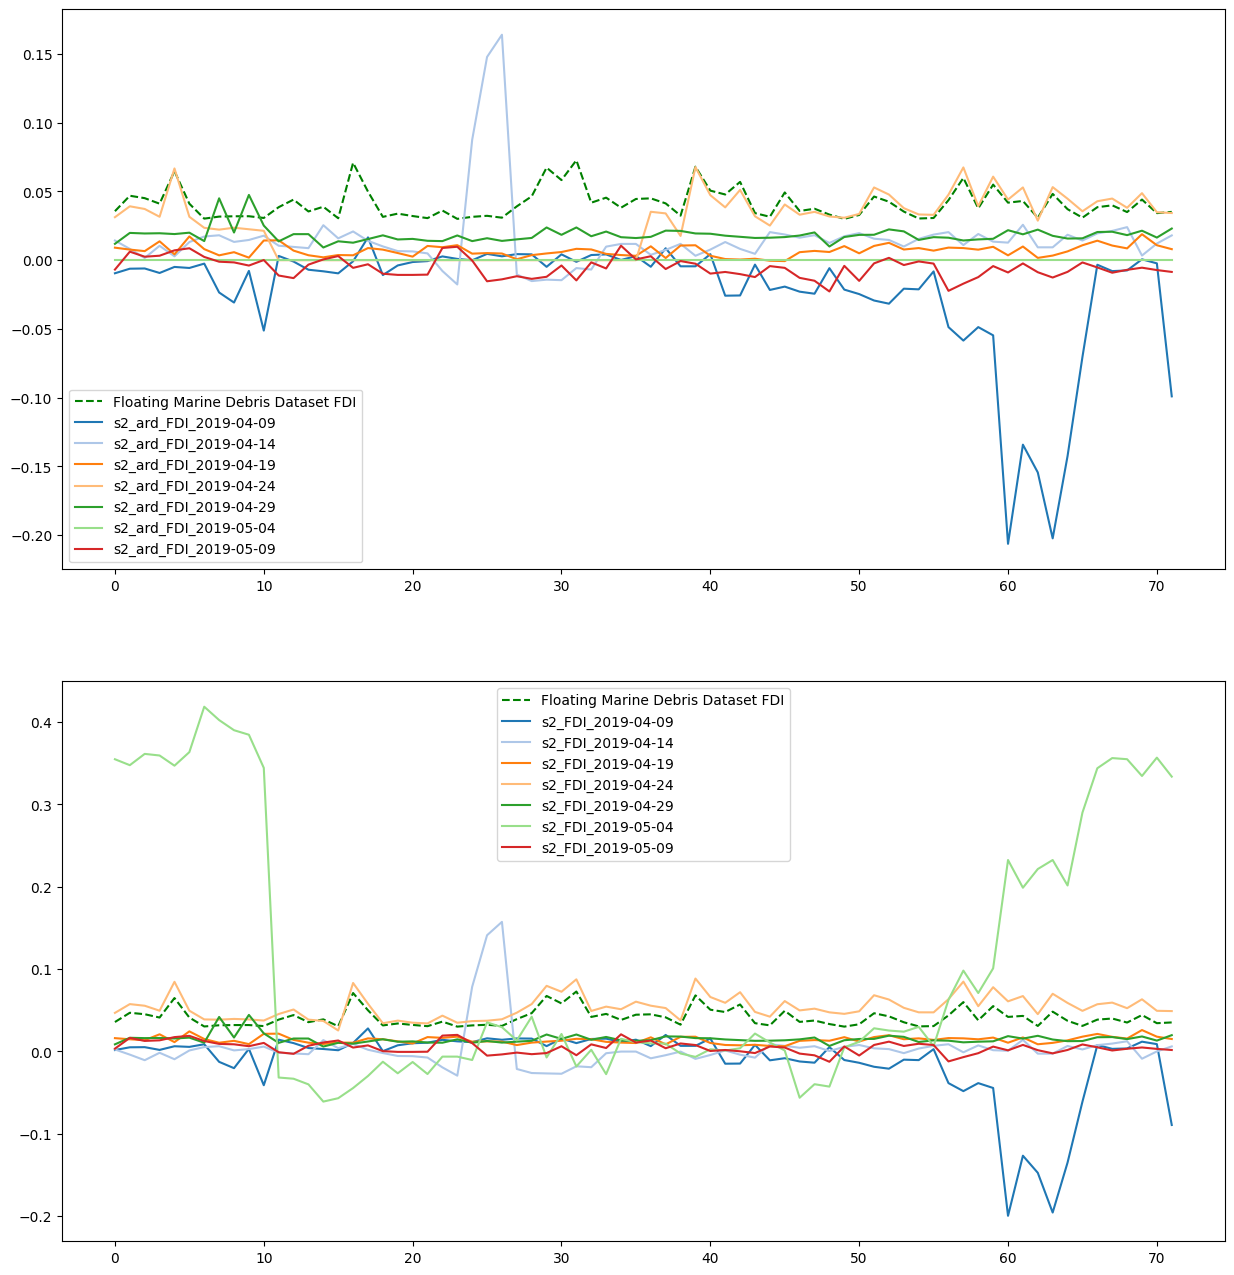

In [14]:
# Compare the FDI values from the Floating Marine Dataset 
# to the values from the Sentinel-2 dataset.

column = "FDI"
columns = [i for i in list(gdf.columns) if column in i]

fig, ax = plt.subplots(2, 1, figsize=(15,16))

marine_debris_dataset[column].plot(ax=ax[0], style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    if gdf[col].notnull().all():
        gdf[col].plot(ax=ax[0], color=color_list[index])

ax[0].legend()
    

columns = [i for i in list(gdf2.columns) if column in i]

marine_debris_dataset[column].plot(ax=ax[1], style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    if gdf2[col].notnull().all():
        gdf2[col].plot(ax=ax[1], color=color_list[index])

ax[1].legend()

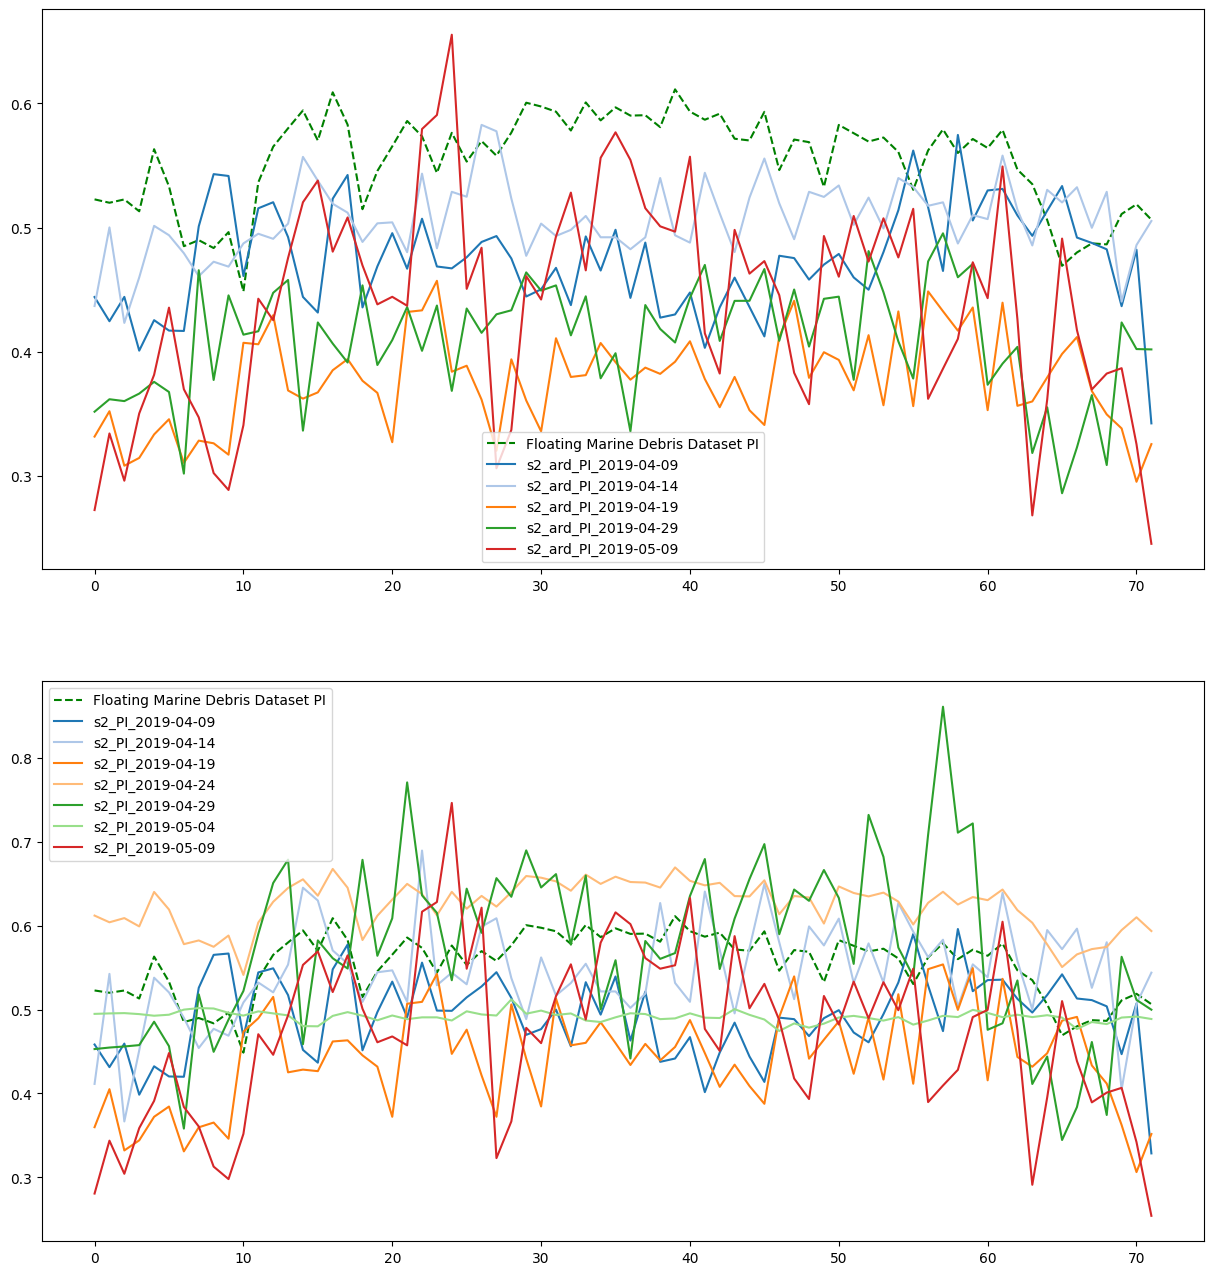

In [15]:
# Compare the Plastic Index values from the Floating Marine Dataset 
# to the values from the Sentinel-2 datasets.

column = "PI"
columns = [i for i in list(gdf.columns) if column in i]

fig, ax = plt.subplots(2, 1, figsize=(15,16))

marine_debris_dataset[column].plot(ax=ax[0], style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    if gdf[col].notnull().all():
        gdf[col].plot(ax=ax[0], color=color_list[index])

ax[0].legend()
    

columns = [i for i in list(gdf2.columns) if column in i]

marine_debris_dataset[column].plot(ax=ax[1], style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):#
    if gdf2[col].notnull().all():
        gdf2[col].plot(ax=ax[1], color=color_list[index])

ax[1].legend()

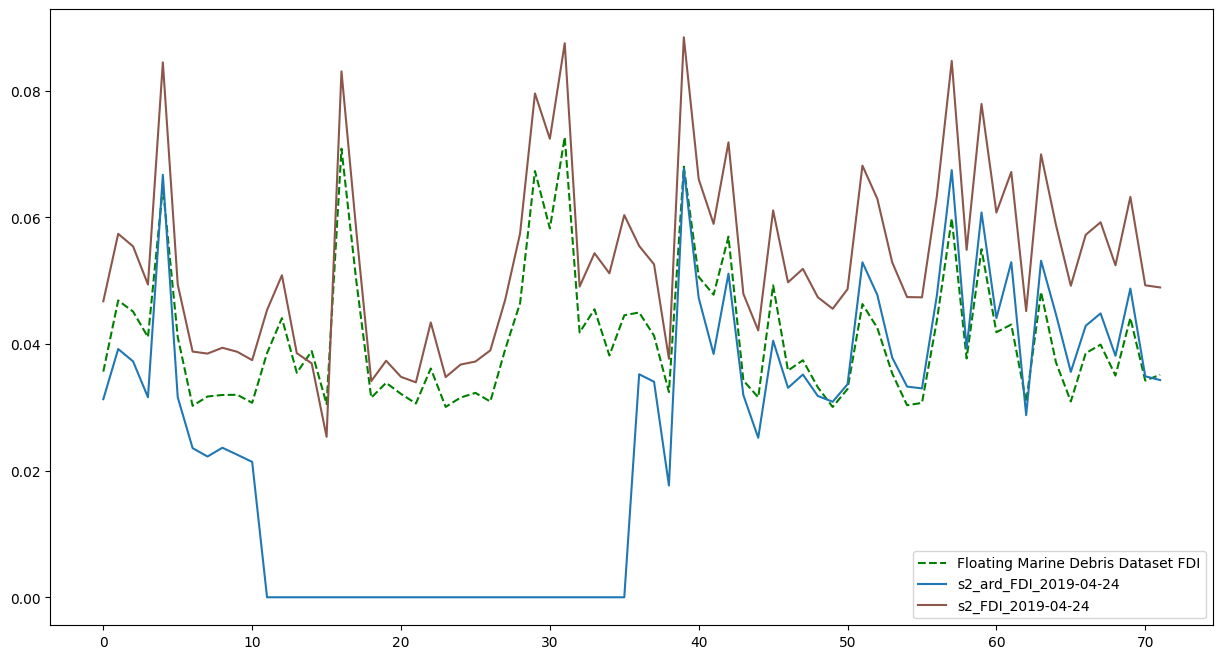

In [16]:
# Plot the Sentinel-2 dates that matches the Floating Dataset Debris values the most. 

col = "FDI"
time = "2019-04-24"
#time = "2018-10-31"

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset[col].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset FDI")

gdf[f's2_ard_{col}_{time}'].plot(ax=ax, color=color_list[0])

gdf2[f's2_{col}_{time}'].plot(ax=ax, color=color_list[10])

plt.legend()

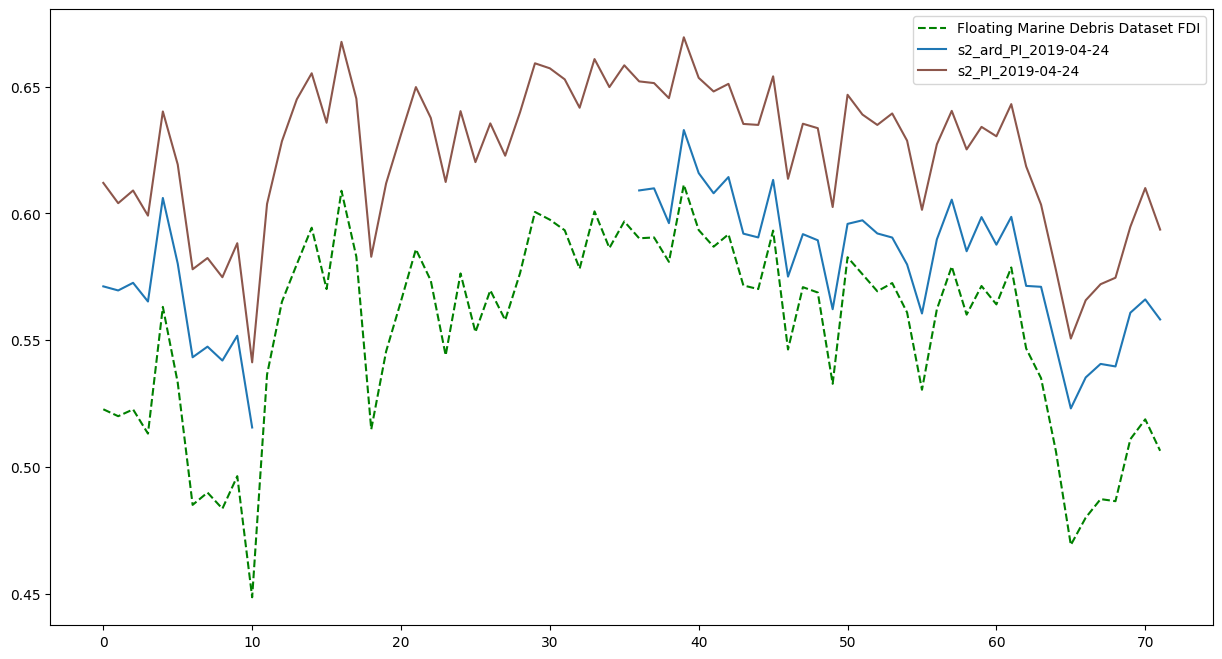

In [17]:
# Plot the Sentinel-2 dates that matches the Floating Dataset Debris values the most. 

col = "PI"
time = "2019-04-24"
#time = "2018-10-31"

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset[col].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset FDI")

gdf[f's2_ard_{col}_{time}'].plot(ax=ax, color=color_list[0])

gdf2[f's2_{col}_{time}'].plot(ax=ax, color=color_list[10])

plt.legend()

In [18]:
# Create a training dataset. 
marine_plastics_training_dataset = gpd.GeoDataFrame(geometry=gpd.GeoSeries(marine_debris_dataset["geometry"])) 
marine_plastics_training_dataset["Country"] = country #marine_debris_dataset["Location"].unique().item()
marine_plastics_training_dataset["Sentinel-2 image date"] = datetime.strptime(str(np.unique(marine_debris_dataset["Date"]).item()), '%Y%m%d').strftime("%Y-%m-%d")

In [19]:
statistics = zonal_stats(marine_plastics_training_dataset, 
                         ds_s2.sel(time=marine_plastics_training_dataset["Sentinel-2 image date"].unique().item()).squeeze()["FDI"].values, 
                         affine=affine, stats=[stats], 
                         nodata=np.nan)

marine_plastics_training_dataset[f"FDI"] = [i[stats] for i in statistics]
marine_plastics_training_dataset.head()

,geometry,Country,Sentinel-2 image date,FDI
0,POINT (2997571.236 -3643584.334),south_africa,2019-04-24,0.046763
1,POINT (2997551.176 -3643594.073),south_africa,2019-04-24,0.057417
2,POINT (2997561.114 -3643594.285),south_africa,2019-04-24,0.055436
3,POINT (2997541.054 -3643604.024),south_africa,2019-04-24,0.049412
4,POINT (2997550.992 -3643604.024),south_africa,2019-04-24,0.084511


In [20]:
# Save the dataset to a geojson file
marine_plastics_training_dataset.to_file(f"data/{country}_floating_marine_debris_training_dataset.geojson", driver="GeoJSON")